In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
from scipy.stats import norm
from scipy.stats import normaltest
import inspect
from functools import partial
from tqdm import tqdm

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline


Say we have the probability space $(\mathbb{\Omega}, \mathcal{B}(\mathbb{\Omega}), \mu) = (\mathbb{R}, \mathcal{B}(\mathbb{R}), \mu)$ where $\mu$ is the uniform measure on the interval $[0,1]$. We can represent samples from this with the following

In [2]:
omega_samples = np.random.random(10000)

Consider an endomorphism on $\mathbb{R}$ in $\mathbf{Para}_{\Omega^{*}}(\mathbf{EucMeas})$ with the functional signature $\Omega \otimes \mathbb{R} \rightarrow \mathbb{R}$. We can view this endomorphism as a stochastic process over our probability space $(\mathbb{R}, \mathcal{B}(\mathbb{R}), \mu)$. An example is the following arrow:

In [3]:
def f(omega, x):
    normal_points = norm(loc=5 - x, scale=10).ppf(omega)
    return normal_points

Let's note that for any fixed $x \in \mathbb{R}$, the random variable $f(-, x)$ over $(\mathbb{R}, \mathcal{B}(\mathbb{R}), \mu)$ has a normal distribution:

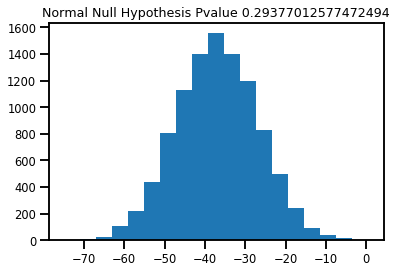

In [4]:
input_x = 42
f_points = f(omega_samples, input_x)
plt.title("Normal Null Hypothesis Pvalue {}".format(normaltest(f_points).pvalue))
h = plt.hist(f_points, bins=(np.linspace(np.min(f_points) - 1, np.max(f_points) + 1, 20)))

Now let's take the composition of $f$ with itself to form the arrow $(f \circ f): \Omega^2 \otimes \mathbb{R} \rightarrow \mathbb{R}$. We write this arrow as:

In [5]:
def ff_para(omega1, omega2, x):
    return f(omega2, f(omega1, x))

We can consider this arrow to be a stochastic process over the product probability space $(\mathbb{R}^2, \mathcal{B}(\mathbb{R}^2), \mu^2)$. Let's note that for any fixed $x \in \mathbb{R}$, the random variable $(f\circ f)(-, -, x)$ over $(\mathbb{R}^2, \mathcal{B}(\mathbb{R}^2), \mu^2)$ has a normal distribution as well:

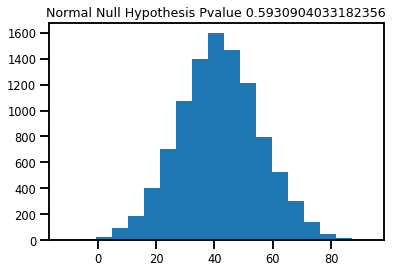

In [6]:
omega2 = np.random.random((10000, 2))
ff_para_points = ff_para(omega2[:, 0], omega2[:, 1], input_x)

plt.title("Normal Null Hypothesis Pvalue {}".format(normaltest(ff_para_points).pvalue))
h = plt.hist(ff_para_points, bins=(np.linspace(np.min(ff_para_points) - 1, np.max(ff_para_points) + 1, 20)))

Now consider the functor $Copy_{\Omega}: \mathbf{Para}_{\Omega^{*}}(\mathbf{EucMeas}) \rightarrow \mathbf{CoKl}_{\Omega}(\mathbf{EucMeas})$. This functor will map our stochastic process
$(f \circ_{\mathbf{Para}} f): \Omega^2 \otimes \mathbb{R} \rightarrow \mathbb{R}$ to the process
$(f \circ_{\mathbf{CoKl}} f): \Omega \otimes \mathbb{R} \rightarrow \mathbb{R}$ such that we have:
$$(f \circ_{\mathbf{CoKl}} f) = Copy_{\Omega} (f \circ_{\mathbf{Para}} f) = (f \circ_{\mathbf{Para}} f) \circ (cp \otimes id)$$
We can implement this functor as follows:


In [7]:
def CopyFunctor(f):
    def g(omega, x, f=f):
        while len(inspect.getargspec(f).args) > 1:
            f = partial(f, omega)
        return f(x)
    return g

We can consider the arrow $(f \circ_{\mathbf{CoKl}} f) = Copy_{\Omega} (f \circ_{\mathbf{Para}} f)$ to be a stochastic process over the probability space $(\mathbb{R}, \mathcal{B}(\mathbb{R}), \mu)$. However, unlike $(f \circ_{\mathbf{Para}} f)$, this stochastic process is not normal for any fixed $x \in \mathbb{R}$. Instead, it's constant:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  This is separate from the ipykernel package so we can avoid doing imports until


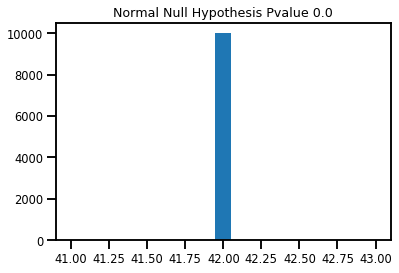

In [8]:
omega = np.random.random(10000)
ff_cokl_points = CopyFunctor(ff_para)(omega, input_x)

plt.title("Normal Null Hypothesis Pvalue {}".format(normaltest(ff_cokl_points).pvalue))
h = plt.hist(ff_cokl_points, bins=(np.linspace(np.min(ff_cokl_points) - 1, np.max(ff_cokl_points) + 1, 20)))

We can also build our stochastic processes with Tensorflow Probability. For example, the following model represents the same stochastic process $f$ above.

Note that the probability measure $\mu$ and the $\omega$ argument fall into the background and are now handled by the sampling logic within the tfp.Distribution class.

W0403 15:26:49.790986 4648101312 deprecation.py:323] From <ipython-input-9-579852ca3670>:10: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


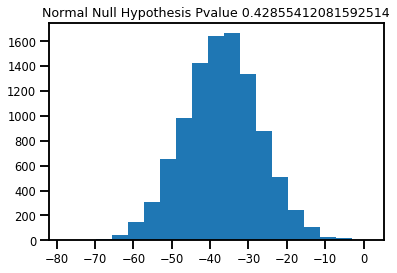

In [9]:
def get_f_tf_layers():
    return [
      tf.keras.layers.Dense(1,
                          kernel_initializer=tf.keras.initializers.Constant(value=-1),
                          bias_initializer=tf.keras.initializers.Constant(value=5)),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=10))
    ]

f_tf = tf.keras.Sequential(get_f_tf_layers())
f_tf_points = f_tf.apply(np.array([input_x] * 10000)[:, None]).sample().numpy().ravel()

plt.title("Normal Null Hypothesis Pvalue {}".format(normaltest(f_tf_points).pvalue))
h = plt.hist(f_tf_points, bins=(np.linspace(np.min(f_tf_points) - 1, np.max(f_tf_points) + 1, 20)))

Let's note that since the sampling for each layer happens independently, Tensorflow Probability implicitly uses $\mathbf{Para}_{\Omega^{*}}(\mathbf{EucMeas})$-composition rather than $\mathbf{CoKl}_{\Omega}(\mathbf{EucMeas})$-composition. We can see this if we look at the composition $f \circ f$ in Tensorflow Probability

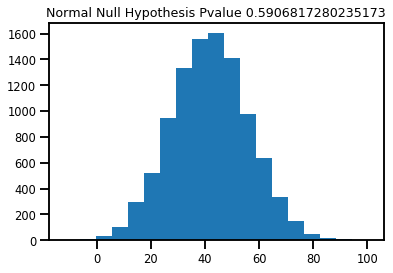

In [10]:
def get_ff_tf_layers():
    return get_f_tf_layers() + get_f_tf_layers()

ff_tf = tf.keras.Sequential(get_ff_tf_layers())
ff_tf_points = ff_tf.apply(np.array([input_x] * 10000)[:, None]).sample().numpy().ravel()

plt.title("Normal Null Hypothesis Pvalue {}".format(normaltest(ff_tf_points).pvalue))
h = plt.hist(ff_tf_points, bins=(np.linspace(np.min(ff_tf_points) - 1, np.max(ff_tf_points) + 1, 20)))

If we lift the parameters in the model definition into the arguments, then we can view our Tensorflow Probability models as $\mathbf{Para}_{\Omega^{*}}(\mathbf{Para}(EucMeas))$ arrows. We can then define the functor $\mathcal{RN}_{\mu}: \mathbf{Para}_{\Omega^{*}}(\mathbf{Para}(EucMeas))_{\mathcal{R}_{\mu}} \rightarrow \mathbf{CondLikelihood}$ in terms of Tensorflow Probability arrows as follows. Note that like the $\omega$ argument, we are keeping the parameter vector argument implicit:

In [11]:
def RnFunctor(model, nsamples=1):
    # We need to take the mean of multiple runs because Tensorflow Probability uses the sample
    #   method to convert inner-layer distributions to tensors
    def likelihood(input_x, y, nsamples=nsamples):
        return np.mean([model.apply(input_x).prob(y) for i in range(nsamples)])
    return likelihood


Let's recall that in $\mathbf{CondLikelihood}$ the composition of the likelihood functions $L$ and $L'$ is

$$  (L' \circ L)(x_{qp}, x_{a}, x_{c}) = \int_{x_b \in \mathbb{R}^b} L'(x_q, x_b, x_c) * L(x_p, x_a, x_b) dx_b $$

In [12]:
def compose_likelihoods(l1, l2, lower, higher, step_size):
    def likelihood(x_a, x_c):
        total_likelihood = 0
        for x_b in np.arange(lower, higher, step_size):
            l1_value = l1(
                input_x=tf.constant([x_a])[None, ...], y=np.array([x_b]))
            l2_value = l2(
                input_x=tf.constant([x_b])[None, ...], y=np.array([x_c]))
            total_likelihood += l1_value * l2_value * step_size
        return total_likelihood
    return likelihood



Now given the arrow $f: \Omega \otimes \mathbb{R} \rightarrow \mathbb{R}$ and its self-composition $(f \circ_{\mathbf{Para}} f): \Omega^2 \otimes \mathbb{R} \rightarrow \mathbb{R}$ we can experimentally demonstrate how:

$$(\mathcal{RN}_{\mu} f) \circ_{\mathbf{CondLikelihood}} (\mathcal{RN}_{\mu} f ) = \mathcal{RN}_{\mu} (f\circ_{\mathbf{Para}} f) $$


In [13]:
composed_likelihood_f = compose_likelihoods(
    l1=RnFunctor(f_tf), l2=RnFunctor(f_tf), lower=-100, higher=0, step_size=0.05)

x_a = 42
x_c = -30
print("Log Likelihood with composition in RN: {}".format(
    np.log(composed_likelihood_f(x_a=x_a, x_c=x_c))))

print("Log Likelihood with composition in Para_O: {}".format(
    np.log(RnFunctor(ff_tf, nsamples=5000)(input_x=tf.constant([x_a])[None, ...], y=np.array([x_c])))))

W0403 15:26:50.206202 4648101312 base_layer.py:1790] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Log Likelihood with composition in RN: -17.117182412049328
Log Likelihood with composition in Para_O: -17.34968376159668


If we set up a target distribution and generate samples, we can use Tensorflow Probability to find the parameters of our stochastic process that maximize the likelihood of those samples under the stochastic process

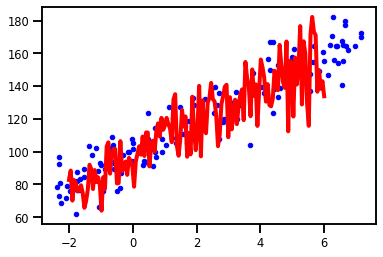

In [14]:
def load_gaussian_linear_dataset(slope=10, intercept=100, scale=10, x_range=[-2, 6], n=150, n_tst=150):
    X = (np.random.random(n) * 1.2 * (x_range[1] - x_range[0]) + 1.2 * x_range[0])[..., np.newaxis]
    Y = (X * slope + intercept)  + np.random.normal(loc=0, scale=scale, size=(n, 1))
    Xt = np.linspace(*x_range, num=n_tst).astype(np.float32)[..., np.newaxis]
    return Y, X, Xt

Y, X, Xt = load_gaussian_linear_dataset()


model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=2)),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Normal(
                           loc=t[..., :1],
                           scale=1e-3 + tf.nn.relu(0.05 * t[..., 1:]))),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=lambda y, p_y: -p_y.log_prob(y))
fit_history = model.fit(X, Y, epochs=10000, verbose=False)

plt.plot(X, Y, 'b.');
plt.plot(Xt,
         np.array([model(np.array(x)[None, :]).sample().numpy() for x in Xt]).ravel(),
         'r', linewidth=4);


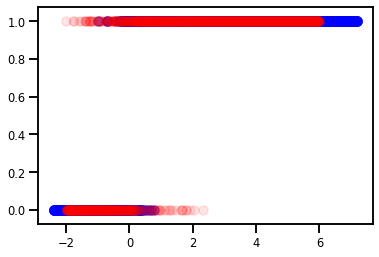

In [17]:
def load_bernoulli_gaussian_dataset(slope=5, intercept=0, scale=2, x_range=[-2, 6], n=1500, n_tst=1500):
    X = (np.random.random(n) * 1.2 * (x_range[1] - x_range[0]) + 1.2 * x_range[0])[..., np.newaxis]
    P = (X * slope + intercept)  + np.random.normal(loc=0, scale=scale, size=(n, 1))
    Y = np.array(P > 0, dtype=np.float32)
    Xt = np.linspace(*x_range, num=n_tst).astype(np.float32)[..., np.newaxis]
    return Y, X, Xt

Y, X, Xt = load_bernoulli_gaussian_dataset()

model = tf.keras.Sequential([
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Normal(
                           loc=t[..., :1],
                           scale=tf.nn.relu(t[..., 1:]))),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Bernoulli(probs=t))
])

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001), loss=lambda y, p_y: -p_y.log_prob(y))
fit_history = model.fit(X, Y, epochs=100, verbose=False)

plt.figure()
plt.scatter(X, Y, color='b', alpha=0.5);
plt.scatter(Xt, model(Xt).sample().numpy(), color='r', alpha=0.1);
